In [352]:
import pandas as pd
import numpy as np
from math import log, exp
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 400

sign = lambda x : 1 if x >= 0 else -1


df = pd.read_csv('./prices250.txt', sep='\s+', header=None, index_col=None)
df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,40.44,4.90,30.92,18.51,47.69,61.70,54.07,18.65,44.13,49.39,...,52.30,38.38,54.80,28.49,31.98,63.15,51.62,11.12,33.32,41.10
1,40.58,4.88,30.95,18.41,47.55,61.38,54.10,18.71,43.97,49.29,...,52.48,38.37,54.78,28.40,32.18,63.15,51.69,11.15,33.35,41.35
2,40.52,4.90,31.02,18.37,47.70,62.10,54.15,18.63,44.13,49.61,...,52.08,38.40,54.82,28.33,32.04,63.16,51.68,11.16,33.31,41.82
3,40.47,4.92,30.98,18.42,47.66,62.70,54.16,18.51,44.22,49.53,...,52.13,38.41,54.83,28.28,31.70,63.19,51.74,11.14,33.70,41.86
4,40.23,4.91,30.93,18.39,48.09,63.06,54.20,18.62,44.55,49.57,...,52.76,38.39,54.80,28.48,31.59,63.19,51.81,11.14,33.76,41.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,43.80,4.13,28.54,17.95,47.41,56.23,52.21,13.96,41.87,49.42,...,48.26,37.11,53.10,26.29,26.27,61.66,50.22,9.81,33.94,38.33
246,43.87,4.13,28.56,17.96,47.11,56.81,52.22,13.81,41.94,49.35,...,48.21,37.14,53.08,26.24,25.97,61.67,50.26,9.81,34.06,38.35
247,43.66,4.14,28.59,18.05,47.13,57.05,52.28,13.84,41.73,49.24,...,48.62,37.14,53.11,26.07,25.74,61.67,50.29,9.82,33.86,38.07
248,43.61,4.14,28.64,18.06,46.72,56.97,52.39,13.86,41.70,49.28,...,48.32,37.17,53.16,26.00,25.96,61.69,50.32,9.81,34.06,39.07


### Strategy
#### 1. Lag Sign Correlation

In [12]:
diff = df.diff().dropna().applymap(sign)

thres = 0.5

max_score = 0
max_past = -1
max_future = -1
max_d = -1

for d in range(1, 20):
    for i in range(100):
        past = diff[i].iloc[:-d].reset_index(drop=True)
        for j in range(100):
            future = diff[j].iloc[d:].reset_index(drop=True)
            score = (sum(past == future) / (249 - d))
            if score > max_score:
                max_score = score
                max_past = past
                max_future = future
                max_d = d

print(max_score, max_d, max_past.name, max_future.name)

# df[max_past.name].iloc[:-1].reset_index(drop=True).plot(figsize=(20, 10))
# df[max_future.name].iloc[1:].reset_index(drop=True).plot(figsize=(20, 10))

#### 2. LogDiff Mean Reversion 

$$argmax_{\text{window}}\sum{I(\text{RMLDP} = \text{df})}$$
$$\implies \text{window} = 8$$

Problem: MR usually overfits and gets the directional movement wrong. to resolve that, we should trade only when we have a statiscially significant movement in the prices. This way we are less prone to high volatility

<AxesSubplot:>

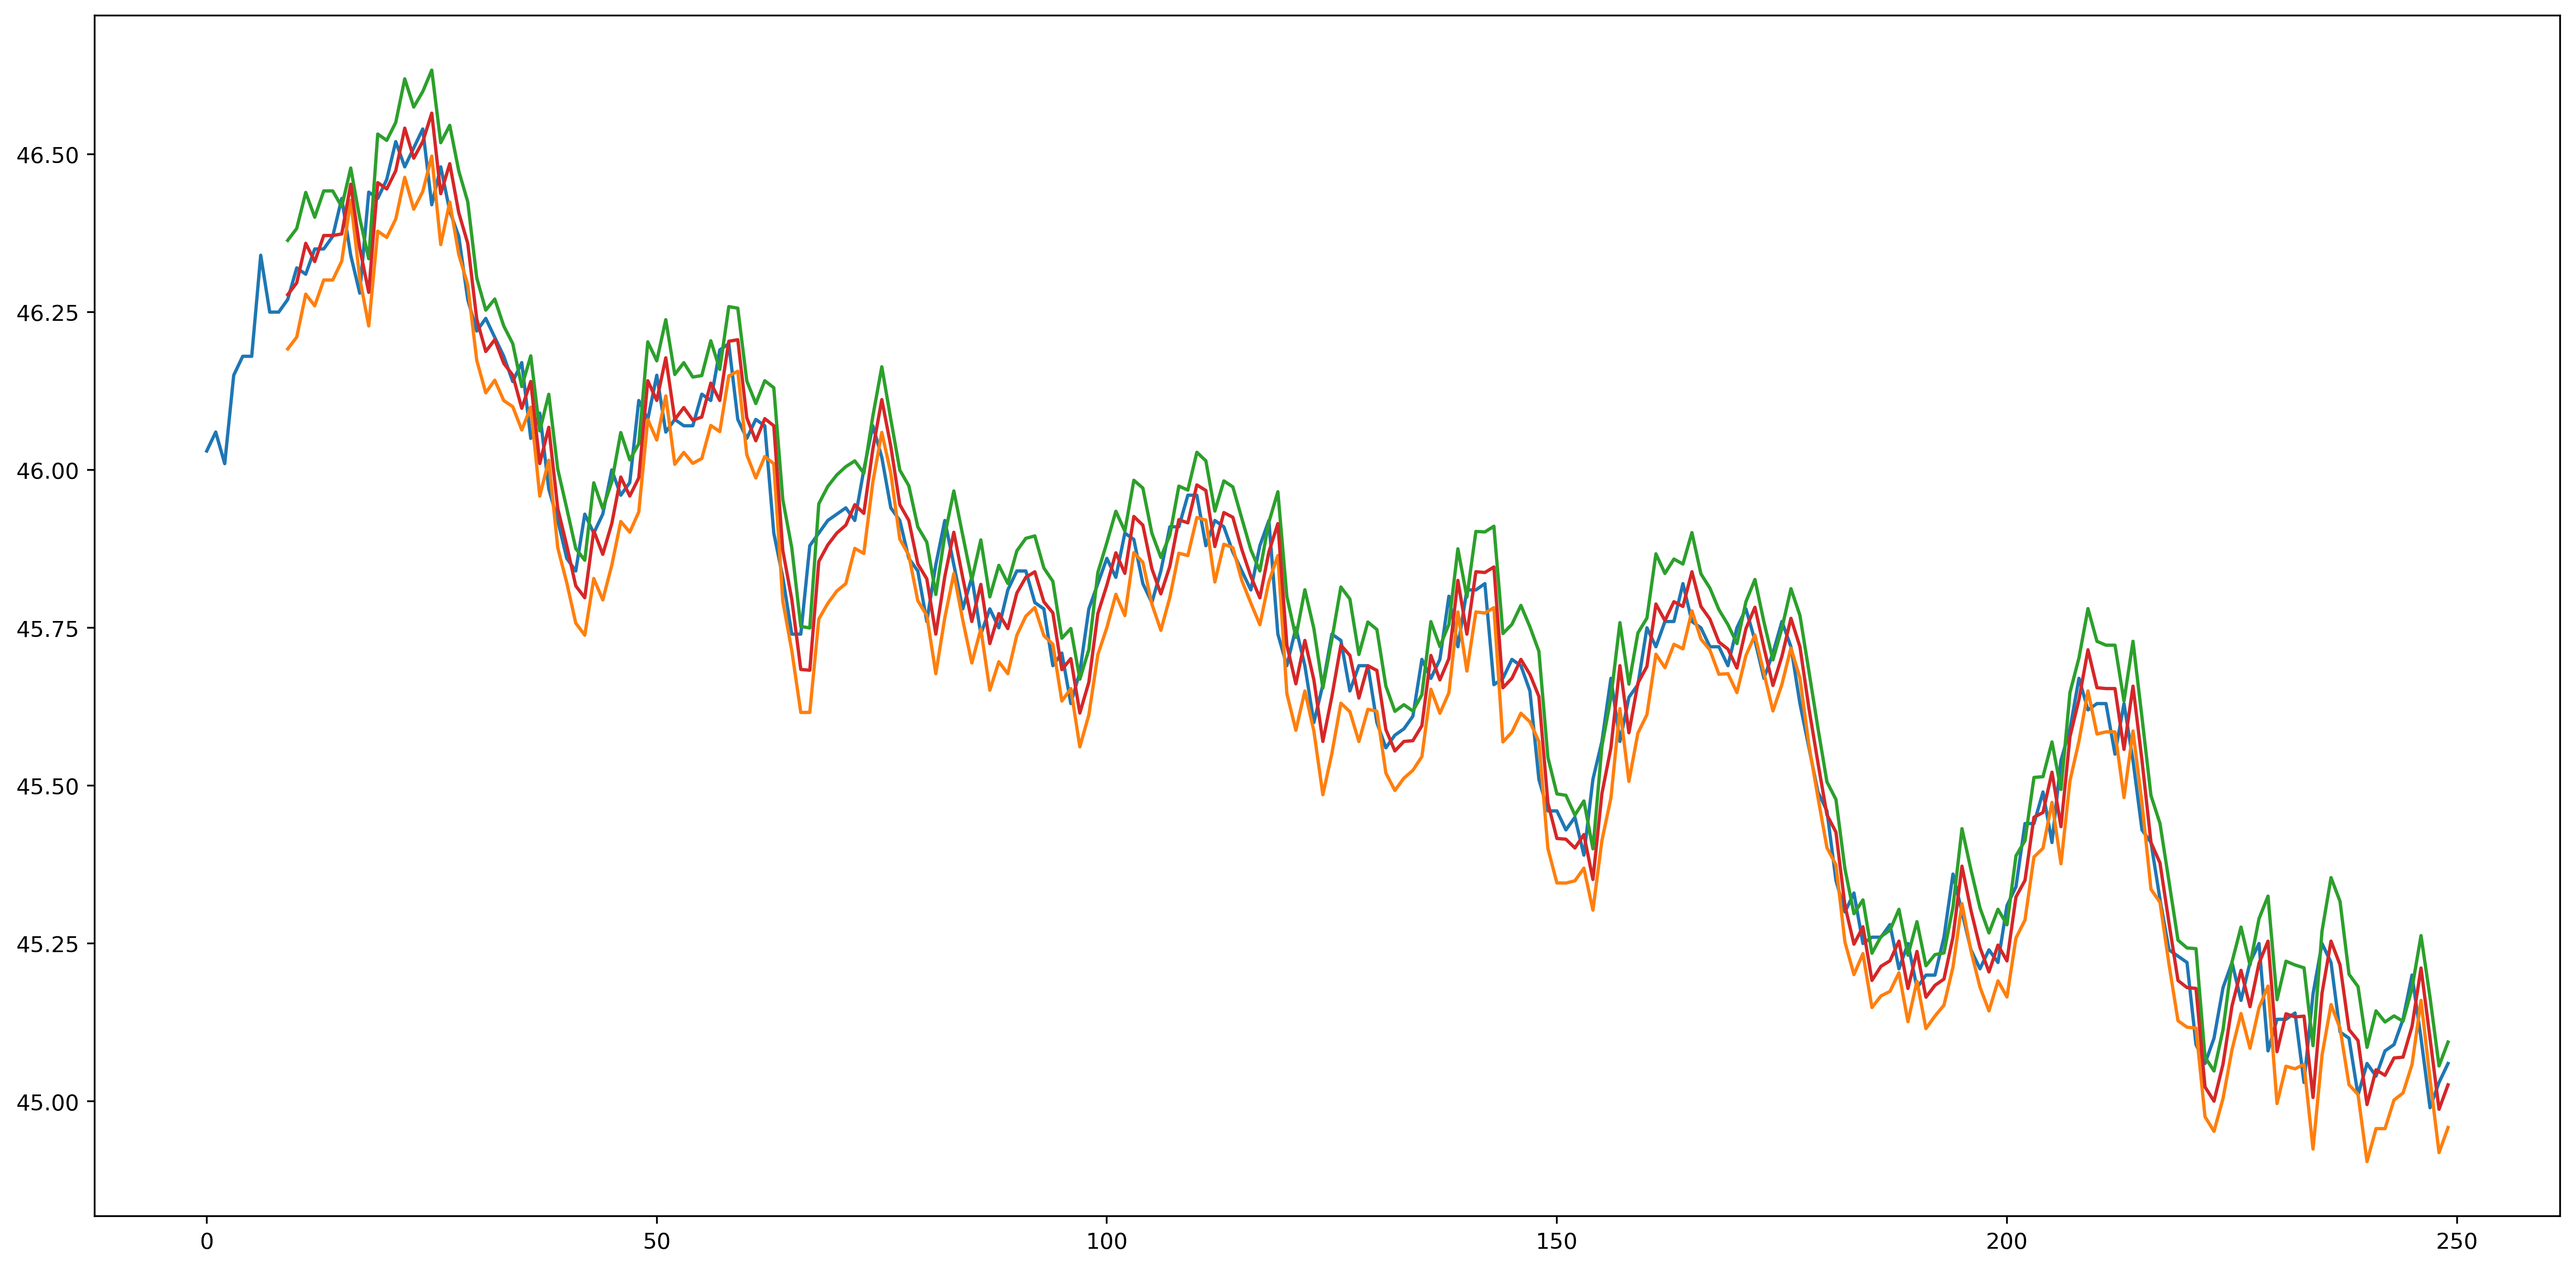

In [389]:
window = 3

LD = df.applymap(log).diff()
RLD = LD.rolling(window)
RMLD = RLD.mean()
RSLD = RLD.std()

RMLDP = ((RMLD).applymap(exp) * df.iloc[window:]).shift(1).dropna()

## Upper and Lower bound for MR

cof = 1
LB = RMLD - (cof * RSLD)
UB = RMLD + (cof * RSLD)

LB = ((LB).applymap(exp) * df.iloc[window:]).shift(1).dropna()
UB = ((UB).applymap(exp) * df.iloc[window:]).shift(1).dropna()

stock = 11

df[stock].plot(figsize=(20, 10))
LB[stock].plot(figsize=(20, 10))
UB[stock].plot(figsize=(20, 10))
RMLDP[stock].plot(figsize=(20, 10))

# RMmatches = (RMLD.dropna().applymap(sign).iloc[:-1].reset_index(drop=True) == LD.iloc[window+1:].applymap(sign).reset_index(drop=True))

# dist = RMmatches.describe().loc['freq'] / RMmatches.describe().loc['count']
# dist.plot(kind='kde', figsize=(8, 4))